# RNA to protein correlation code

Here we examine how correlated the trancsript abundance (CPM) is compared to protein abundance (PSM count).


In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import os
import matplotlib 
from huvec_analysis import huvec_config  #parameters for plotting

# Import the fonts from the huvec_config file 
matplotlib.rc('font', **huvec_config.font)


# All plots go into a directory
plot_dir = 'plot'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# All of the stats go into a directory
stats_dir = 'stats'
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)


In [2]:


#file paths 
filtered_protein_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/protein_filter/huvec.classification_filtered.tsv' #filtered protein file 
peptide_path = '../00_pre_analysis/metamorpheus_table/AllPeptides.PacBioHybrid.tsv'


filtered_protein = pd.read_table(filtered_protein_path)
filtered_protein['gene'] = filtered_protein['pr_gene']
#filtered_protein = filtered_protein[filtered_protein['pb'].isin(data_loader.acs_in_hiconf_space)]
filtered_protein = filtered_protein[['pb', 'gene', 'CPM']]

# transform the peptide data
peptides = pd.read_table(peptide_path)
peptides = peptides.rename(columns = {'PSM Count (unambiguous, <0.01 q-value)':'PSM'})
peptides['Protein Accession'] = peptides['Protein Accession'].str.split('|')
peptides = peptides.explode('Protein Accession')

# Plot the correlation of peptide PSM vs CPM group by gene 
# Each line in the table is a peptide value 
merged = pd.merge(filtered_protein, peptides, how = 'left', right_on= 'Protein Accession', left_on= 'pb')
gene_grouped = merged.groupby('gene').sum()
gene_grouped['log2(PSM+1)'] = np.log2(gene_grouped['PSM'] +1)
gene_grouped['log2(CPM+1)'] = np.log2(gene_grouped['CPM'] +1)



### Plot transcript vs protein correlation

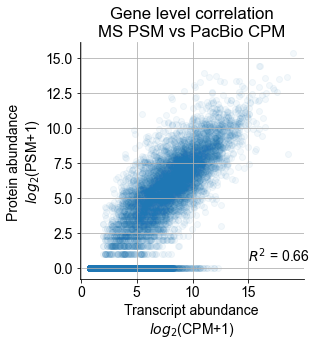

In [3]:

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_grouped['log2(CPM+1)'],gene_grouped['log2(PSM+1)'])
sns.lmplot(data=gene_grouped, x = 'log2(CPM+1)', y = 'log2(PSM+1)', scatter_kws={'alpha':0.05},fit_reg=False, height=4) 
plt.rc('axes', axisbelow=True)
plt.grid()
plt.xlabel('Transcript abundance\n$log_2$(CPM+1)')
plt.ylabel('Protein abundance \n$log_2$(PSM+1)')
plt.title('Gene level correlation\nMS PSM vs PacBio CPM')
plt.text(15, 0.5, '$R^2$ = %0.2f' % r_value**2)
plt.savefig(f'plot/correlation_gene_level_psm_cpm_hybrid.png', dpi=300, bbox_inches='tight')


In [5]:
gene_grouped[['CPM', 'PSM', 'log2(PSM+1)', 'log2(CPM+1)']].to_csv('stats/protein_transcript_correlation.tsv', sep='\t')